In [2]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from copy import deepcopy

from keras import models
from keras.layers import Dense, Dropout


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


ValueError: x and y must have same first dimension, but have shapes (21,) and (101,)

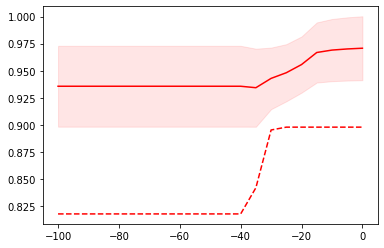

In [7]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, Ship squares, Current quantity
# Algorithms:
# linear regression
# Dummy limit


# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, ship_squares, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON r.project_id=a.project_id"
    " GROUP BY r.project_id, gross_tonnage, prototype, ship_squares")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
sq = data[:, 3]
gts = data[:, [1, 3]]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

model = linear_model.LinearRegression()

all_dummy_acc = []
for train_i, test_i in lpo.split(y):
    # train regression model
    model.fit(gts[train_i].reshape(-1, 2), y[train_i])
    # collect time series train data
    start = -100
    step = 5
    sequences = []
    ys = []
    dum_lim = 0
    linear_preds = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = model.predict(gts[[i]].reshape(1, 2))[0]
            linear_preds.append(linear_pred)
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            sequences.append(sequence)
            ys.append(y[i])
            
    best_dum_err = np.inf
    for lim1 in np.linspace(0.5, 1.0, 30):
        errs = []
        for i, sequence in enumerate(sequences):
            linear_pred = linear_preds[i]
            if sequence.sum()>lim1*linear_pred:
                pred = sequence.sum()
            else:
                pred = linear_pred
            errs.append(np.square(ys[i]-pred))
        errs = np.array(errs)
        if errs.max() < best_dum_err:
            best_dum_err = errs.max()
            dum_lim = lim1
    # evaluate model
    dummy_accs = []
    x = []
    
    for wk in range(start, 1, step):
        y_reals = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = model.predict(gts[[i]].reshape(1, 2))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            xseq = data[:, 0]
            if sequence.sum()>dum_lim*linear_pred:
                dummy_preds.append(sequence.sum())
            else:
                dummy_preds.append(linear_pred) # normally linear pred here
            y_reals.append(y[i])
        dummy_mape = mape(y_reals, dummy_preds)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)

    all_dummy_acc.append(dummy_accs)


all_dummy_acc = np.array(all_dummy_acc)
np.save('dynamic_dummy_quantity5.npy', all_dummy_acc)
all_dummy_acc2 = np.load('dynamic_dummy_quantity_gt.npy', allow_pickle=True)

plt.plot(x, all_dummy_acc.mean(axis=0), 'r')
plt.plot(x, all_dummy_acc.min(axis=0), 'r--')
plt.fill_between(x, all_dummy_acc.mean(axis=0) - all_dummy_acc.std(axis=0),
                all_dummy_acc.mean(axis=0) + all_dummy_acc.std(axis=0),
                alpha=0.1, color='r')

plt.plot(x, all_dummy_acc2.mean(axis=0), 'b')
plt.plot(x, all_dummy_acc2.min(axis=0), 'b--')
plt.fill_between(x, all_dummy_acc2.mean(axis=0) - all_dummy_acc2.std(axis=0),
                all_dummy_acc2.mean(axis=0) + all_dummy_acc2.std(axis=0),
                alpha=0.1, color='b')

#plt.ylim(0.7, 1.1)
plt.grid(which='major')

plt.show()
